In [ ]:

from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('WeatherDataProcessing').getOrCreate()

In [ ]:
df = spark.read.csv(r'C:\Users\aravi\Desktop\Assignment\GlobalWeatherRepository.csv', header=True, inferSchema=True)

In [ ]:
df.printSchema()

In [ ]:
from pyspark.sql.functions import to_date, col

In [ ]:
df = df.withColumn('date_only', to_date(col('last_updated')))

In [ ]:
df.show()

In [ ]:
df.printSchema()

In [ ]:
df = df.withColumn("date", df["date_only"].cast("date"))

In [ ]:
from pyspark.sql.functions import year
df = df.withColumn("year", year(df["date_only"]))

In [ ]:
df.show()

In [ ]:
df.printSchema()

In [ ]:
df.select("year").show()

In [ ]:
from pyspark.sql.functions import month
df = df.withColumn("month", month(df["date"]))

In [ ]:
df.select("month").show()

In [ ]:
from pyspark.sql.functions import dayofmonth
df = df.withColumn("day", dayofmonth(df["date"]))

In [ ]:
df.select("date", "day").show()

In [ ]:
df.printSchema()

In [ ]:
df.select("precip_mm").show()

In [ ]:
df.select("temperature_fahrenheit").show()

In [ ]:
from pyspark.sql.types import FloatType
df = df.withColumn("precip_in", df["precip_in"].cast(FloatType()))

In [ ]:
df.printSchema()

In [ ]:
df = df.na.fill({"precip_in": 0.0})

In [ ]:
df.select("precip_in").show(10)

In [ ]:
from pyspark.sql.functions import mean, sum

# Aggregate by month
monthly_data = df.groupBy("year", "month").agg(
    mean("temperature_fahrenheit").alias("avg_temperature"),
    sum("precip_in").alias("total_precipitation")
)

# Select and show the average temperature
#monthly_data.select("avg_temperature").show()


In [ ]:
monthly_data.show()

In [ ]:
ordered_monthly_data = monthly_data.orderBy("month")

In [ ]:
ordered_monthly_data.show()

In [ ]:

daily_precipitation = df.groupBy("year", "month", "day").agg(
    sum("precip_in").alias("total_precipitation")
)


In [ ]:

# Group by year and month and calculate the average temperature and total precipitation
monthly_data = df.groupBy("year", "month").agg(
    mean("temperature_fahrenheit").alias("avg_temperature"),
    sum("precip_in").alias("total_precipitation")
)

# Show the result
monthly_data.show()



In [ ]:
# Daily Aggregation
daily_data = df.groupBy("year", "month", "day").agg(
    mean("temperature_fahrenheit").alias("avg_temperature"),
    sum("precip_in").alias("total_precipitation")
)
daily_data.show()

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Display the Pandas DataFrame
pandas_df


In [ ]:
#Check whether there is null values

pandas_df.isnull().sum()

In [ ]:
#checking for duplicates
duplicates = pandas_df.duplicated()
pandas_df[duplicates]

In [ ]:
#Calculate rolling averages and rolling sums
from pyspark.sql.window import Window
#Define window specifications
windowSpec = Window.orderBy("date").rowsBetween(-2, 0)  # Rolling window of 3 days
from pyspark.sql.functions import avg, sum, col
df_with_rolling_avg = df.withColumn("rolling_avg_temperature", avg("temperature_fahrenheit").over(windowSpec))
df_with_rolling_avg = df_with_rolling_avg.withColumn("rolling_avg_precip", avg("precip_in").over(windowSpec))
df_with_rolling_avg = df_with_rolling_avg.withColumn("rolling_sum_precip", sum("precip_in").over(windowSpec))
df_with_rolling_avg.show()

In [ ]:
#calculating statistics
from pyspark.sql.functions import mean, sum, count, min, max
statistics = df.agg(
    mean("temperature_fahrenheit").alias("mean_temperature"),
    sum("temperature_fahrenheit").alias("sum_temperature"),
    count("temperature_fahrenheit").alias("count_temperature"),
    min("temperature_fahrenheit").alias("min_temperature"),
    max("temperature_fahrenheit").alias("max_temperature"),
    mean("precip_in").alias("mean_precipitation"),
    sum("precip_in").alias("sum_precipitation"),
    count("precip_in").alias("count_precipitation"),
    min("precip_in").alias("min_precipitation"),
    max("precip_in").alias("max_precipitation")
)
statistics.show()

In [ ]:
from pyspark.sql.functions import col, abs, mean, stddev
# Define a function to calculate Z-score and identify outliers for a given column
def detect_outliers(df, column):
    stats = df.select(mean(col(column)).alias("mean_val"),
                      stddev(col(column)).alias("stddev_val")).first()
   
    mean_val = stats["mean_val"]
    stddev_val = stats["stddev_val"]
   
    df_with_zscore = df.withColumn("z_score", (col(column) - mean_val) / stddev_val)
    outliers = df_with_zscore.filter(abs(col("z_score")) > 3)
    return outliers
 
# Check for outliers in 'temperature_fahrenheit'
outliers_temp = detect_outliers(df, "temperature_fahrenheit")
print("Outliers in temperature_fahrenheit:")
outliers_temp.show()
 
# Check for outliers in 'precip_in'
outliers_precip = detect_outliers(df, "precip_in")
print("Outliers in precip_in:")
outliers_precip.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs, mean, stddev, expr
 
 
 
# Function to detect outliers using Z-score
def detect_outliers(df, column):
    stats = df.select(mean(col(column)).alias("mean_val"),
                      stddev(col(column)).alias("stddev_val")).first()
   
    mean_val = stats["mean_val"]
    stddev_val = stats["stddev_val"]
   
    df_with_zscore = df.withColumn("z_score", (col(column) - mean_val) / stddev_val)
    outliers = df_with_zscore.filter(abs(col("z_score")) > 3)
    return outliers, mean_val, stddev_val
 
# Function to replace outliers with median value
def replace_outliers(df, column, mean_val, stddev_val):
    stats = df.selectExpr(f"percentile_approx({column}, 0.5)").collect()
    median_val = stats[0][0]
   
    df_with_replaced = df.withColumn(column,
                                     expr(f"CASE WHEN abs((`{column}` - {mean_val}) / {stddev_val}) > 3 THEN {median_val} ELSE `{column}` END"))
    return df_with_replaced
 
# Detect and replace outliers in 'temperature_fahrenheit'
outliers_temp, mean_val_temp, stddev_val_temp = detect_outliers(df, "temperature_fahrenheit")
df_cleaned = replace_outliers(df, "temperature_fahrenheit", mean_val_temp, stddev_val_temp)
 
# Detect and replace outliers in 'precip_in'
outliers_precip, mean_val_precip, stddev_val_precip = detect_outliers(df_cleaned, "precip_in")
df_cleaned = replace_outliers(df_cleaned, "precip_in", mean_val_precip, stddev_val_precip)
 
# Drop the z_score column
df_cleaned = df_cleaned.drop("z_score")


In [ ]:
df1 = spark.read.csv(r'C:\Users\aravi\Desktop\Assignment\cleaned_weather_data.csv', header=True, inferSchema=True)

In [ ]:
df1.show()

In [ ]:
from pyspark.sql import SparkSession
 
 
 
# Perform an anti-join to find rows in the old dataset that are not in the new dataset
diff_old_to_new = df.join(df1, on=['country'], how='left_anti')
 
# Perform an anti-join to find rows in the new dataset that are not in the old dataset
diff_new_to_old = df1.join(df, on=['country'], how='left_anti')
 
# Show the differences
print("Differences from old to new dataset:")
diff_old_to_new.show()
 
print("Differences from new to old dataset:")
diff_new_to_old.show()

+----+-----------------+
|year|         avg_temp|
+----+-----------------+
|2024|74.67437990510241|
|2025|64.49001643835615|
+----+-----------------+

+----+-----+-----------------+
|year|month|         avg_temp|
+----+-----+-----------------+
|2025|    1|64.37855477855472|
|2025|    2|64.70464892593793|
|2024|    5|77.27550030321397|
|2024|    6|79.62250731875338|
|2024|    7|80.24264468733195|
|2024|    8| 80.2230934656741|
|2024|    9|77.22641734972692|
|2024|   10|  72.253438538206|
|2024|   11|67.30173629018384|
|2024|   12|64.84564102564129|
+----+-----+-----------------+



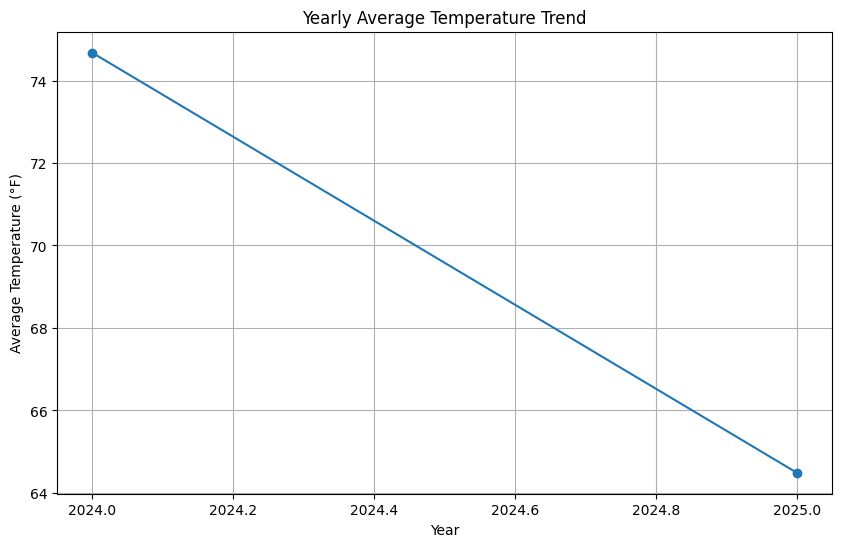

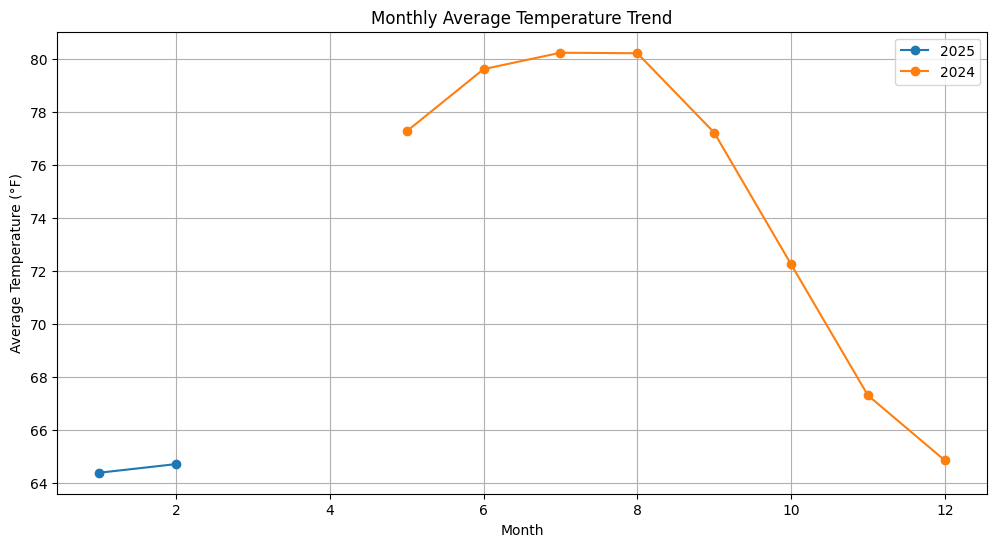

In [54]:
from pyspark.sql.functions import col, avg, to_date, month, year
# Group data by year and calculate average temperature
df_yearly_avg = df_cleaned.groupBy(year(col('date')).alias('year')).agg(avg(col('temperature_fahrenheit')).alias('avg_temp'))
 
# Show yearly average temperature
df_yearly_avg.show()
 
# Group data by month and calculate average temperature
df_monthly_avg = df_cleaned.groupBy(year(col('date')).alias('year'), month(col('date')).alias('month')).agg(avg(col('temperature_fahrenheit')).alias('avg_temp')).orderBy('month')
 
# Show monthly average temperature
df_monthly_avg.show()
 
# Convert DataFrame to Pandas for visualization
df_yearly_avg_pandas = df_yearly_avg.toPandas()
df_monthly_avg_pandas = df_monthly_avg.toPandas()
 
import matplotlib.pyplot as plt
 
# Plot yearly average temperature
plt.figure(figsize=(10, 6))
plt.plot(df_yearly_avg_pandas['year'], df_yearly_avg_pandas['avg_temp'], marker='o')
plt.title('Yearly Average Temperature Trend')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.show()
 
# Plot monthly average temperature
plt.figure(figsize=(12, 6))
for year in df_monthly_avg_pandas['year'].unique():
    yearly_data = df_monthly_avg_pandas[df_monthly_avg_pandas['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['avg_temp'], marker='o', label=str(year))
plt.title('Monthly Average Temperature Trend')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.legend()
plt.show()

+----+--------------------+
|year|          avg_precip|
+----+--------------------+
|2024|0.003560907544510...|
|2025|0.003035616388672...|
+----+--------------------+

+----+-----+--------------------+
|year|month|          avg_precip|
+----+-----+--------------------+
|2025|    1|0.003058608009470946|
|2025|    2|0.002991343328550711|
|2024|    5| 0.00412067913339039|
|2024|    6|0.003543998567194...|
|2024|    7|0.003936570448458...|
|2024|    8|0.003892473061472...|
|2024|    9| 0.00380635240224643|
|2024|   10|0.003270764067843309|
|2024|   11|0.003359119773028908|
|2024|   12|0.002838709632765172|
+----+-----+--------------------+



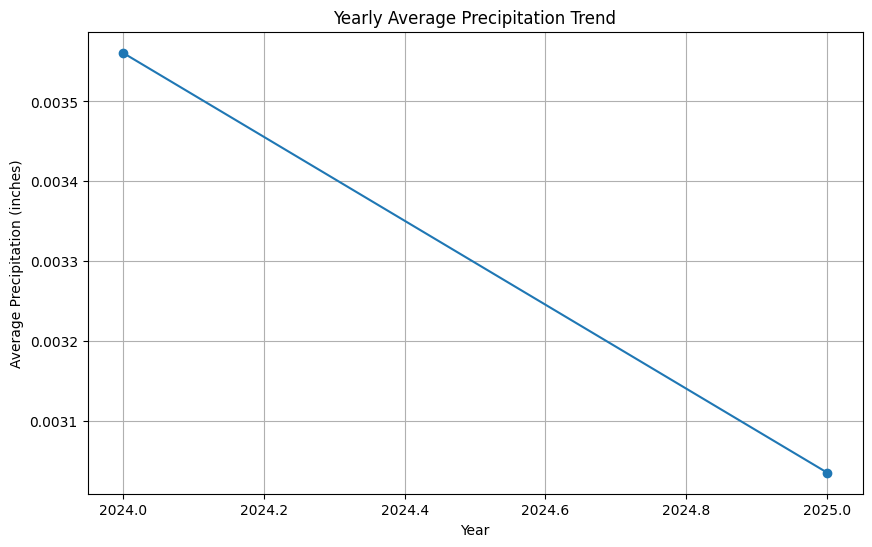

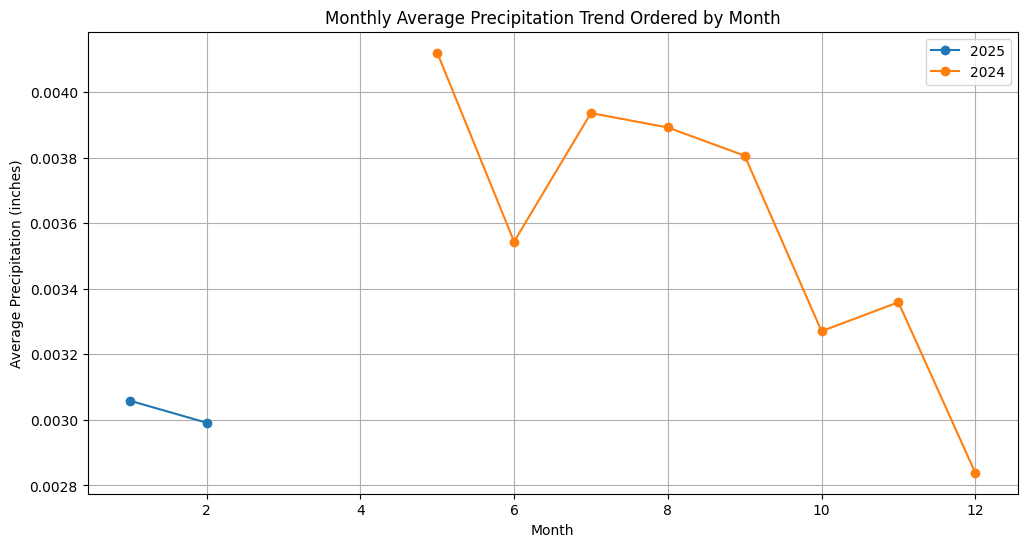

In [55]:
from pyspark.sql.functions import col, avg, to_date, month, year
# Group data by year and calculate average precipitation
df_yearly_avg = df_cleaned.groupBy(year(col('date')).alias('year')).agg(avg(col('precip_in')).alias('avg_precip'))
 
# Show yearly average precipitation
df_yearly_avg.show()
 
# Group data by year and month, calculate average precipitation, and order by month
df_monthly_avg = df_cleaned.groupBy(year(col('date')).alias('year'), month(col('date')).alias('month')).agg(avg(col('precip_in')).alias('avg_precip')).orderBy('month')
 
# Show monthly average precipitation ordered by month
df_monthly_avg.show()
 
# Convert DataFrame to Pandas for visualization
df_yearly_avg_pandas = df_yearly_avg.toPandas()
df_monthly_avg_pandas = df_monthly_avg.toPandas()
 
import matplotlib.pyplot as plt
 
# Plot yearly average precipitation
plt.figure(figsize=(10, 6))
plt.plot(df_yearly_avg_pandas['year'], df_yearly_avg_pandas['avg_precip'], marker='o')
plt.title('Yearly Average Precipitation Trend')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (inches)')
plt.grid(True)
plt.show()
 
# Plot monthly average precipitation ordered by month
plt.figure(figsize=(12, 6))
for year in df_monthly_avg_pandas['year'].unique():
    yearly_data = df_monthly_avg_pandas[df_monthly_avg_pandas['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['avg_precip'], marker='o', label=str(year))
plt.title('Monthly Average Precipitation Trend Ordered by Month')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (inches)')
plt.grid(True)
plt.legend()
plt.show()